In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


from tensorflow.keras.layers import Input, Dense, concatenate, LSTM, Bidirectional, Dropout, GRU
from tensorflow.keras.models import Model
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)


# Modeling using both types of data
As said before, the data presented has a static dimension as well as a continuous/dynamic dimension. to access all information we need both a recurrent network and a deep network. After both data go through a couple of its respective layers they will be concatenated and go through a dense layer with a sigmoid function. Back prop will adjust weight from both neworks and find minimal loss/ max acc .

In [2]:
df_static = pd.read_csv('../treated_data/df_static2.csv',index_col=0)
df_dynamic = pd.read_csv('../treated_data/df_dynamic.csv', index_col=0)

/home/mateus/anaconda3/envs/home-credit/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Train test split
the split is using just the SK_ID_CURR that later will .loc() the other features from both dfs

In [3]:
X_train, X_test, y_train, y_test  = train_test_split(df_static.index ,df_static.TARGET, test_size=0.33, random_state=42, shuffle=True)

In [4]:
X_static_train = df_static.loc[X_train]
X_static_train = X_static_train.fillna(X_static_train.mean()).iloc[:,1:]

X_static_test = df_static.loc[X_test]
X_static_test = X_static_test.fillna(X_static_train.mean()).iloc[:,1:]

Dynamic data needs to be pivoted on SK_ID_CURR so each observation has 97 months for each of the 57 features

After pivoting the columns are organized as 97 months of first feature, 97 months of second feature and so on.
df has to be reshaped into a 3d array with (ID, MONTH, FEATURES). Fortran-like order is used for every number to fall in place

In [5]:
X_dynamic_train = df_dynamic.loc[X_train].reset_index()
X_dynamic_train = X_dynamic_train.fillna(0)
X_dynamic_train = X_dynamic_train.pivot_table(values=list(set(X_dynamic_train.columns)-set(['SK_ID_PREV', 'MONTHS_BALANCE','SK_ID_CURR'])), index='SK_ID_CURR', columns='MONTHS_BALANCE',aggfunc='sum', fill_value=0).loc[X_train].values
X_dynamic_train = X_dynamic_train.reshape((33265,97,57), order = 'F')

X_dynamic_test = df_dynamic.loc[X_test].reset_index()
X_dynamic_test = X_dynamic_test.fillna(0)
X_dynamic_test = X_dynamic_test.pivot_table(values=list(set(X_dynamic_test.columns)-set(['SK_ID_PREV', 'MONTHS_BALANCE','SK_ID_CURR'])), index='SK_ID_CURR', columns='MONTHS_BALANCE',aggfunc='sum', fill_value=0).loc[X_test].values
X_dynamic_test = X_dynamic_test.reshape((16385,97,57), order = 'F')

# Scaling
Is always a good idea to scale data to prevent high magnitude weighting too much on euclidean distance calculation. when using neural networks it is even more essential because input neurons expect values [0:1].

dynamic data needs special treatment, each feature has to be scaled through every time step and for every SK

In [6]:
scaler = MinMaxScaler()
X_static_train = scaler.fit_transform(X_static_train)
X_static_test = scaler.transform(X_static_test)

In [7]:
scalers = {}
for i in range(X_dynamic_train.shape[2]):
    scalers[i] = MinMaxScaler()
    X_dynamic_train[:, :, i] = scalers[i].fit_transform(X_dynamic_train[:, :, i]) 

for i in range(X_dynamic_test.shape[2]):
    X_dynamic_test[:, :, i] = scalers[i].transform(X_dynamic_test[:, :, i]) 

# Model
has two inputs, dy that has shape (time steps, number of features) and st has shape (number of features), each input goes through an independent network. 
dy will go through a LSTM that outputs 70 neurons followed by a dense layer
st will go through a Dense that outputs 40 neurons, dropout 0.5 and another dense that outputs 30 neurons.
the output of those two branches will be concatenated on layes z that  output 60 neurons.
a last dense relu layer will be used before the last sigmoid layer

In [8]:
x_in_dy = Input(shape=(48,57))
x_in_st = Input(shape=(186))

x_dy = LSTM(70, return_sequences=False)(x_in_dy)
x_dy = Dense(30)(x_dy)

x_st = Dense(40, activation="relu")(x_in_st)
x_st = Dropout(0.5)(x_st)
x_st = Dense(30, activation="relu")(x_st)


z=concatenate([x_dy,x_st])

out = Dense(24, activation='relu')(z)
out = Dense(1, activation='sigmoid')(out)


model1 = Model(inputs = [x_in_dy,x_in_st], outputs = out)

## Compile
The arguments used for compiling model are speciffic for a binary classification problem
optimizer = Stochastic Gradient Descent with momentum
loss = Binary Crossentropy
metric = Area under the ROC Curve

In [9]:
opt = tf.keras.optimizers.SGD(lr=0.01, momentum=0.7)
m = tf.keras.metrics.AUC(num_thresholds=100)

model1.compile(optimizer=opt, loss = 'binary_crossentropy', metrics=[m])

## Model
considering the trade-off data size/ time to process it was verified that the last 2 years (48 months) had the most information. 

models starts do overfit after 150 epochs

In [10]:
history = model1.fit([X_dynamic_train[:,-48:,:],X_static_train], y_train,
                     validation_data=([X_dynamic_test[:,-48:,:], X_static_test], y_test),
                    epochs=150, batch_size= 500)

Epoch 1/150
67/67 [==============================] - 3s 43ms/step - loss: 0.6967 - auc: 0.5224 - val_loss: 0.6894 - val_auc: 0.5671
Epoch 2/150
67/67 [==============================] - 3s 39ms/step - loss: 0.6894 - auc: 0.5487 - val_loss: 0.6871 - val_auc: 0.5863
Epoch 3/150
67/67 [==============================] - 3s 39ms/step - loss: 0.6869 - auc: 0.5654 - val_loss: 0.6848 - val_auc: 0.5988
Epoch 4/150
67/67 [==============================] - 3s 40ms/step - loss: 0.6851 - auc: 0.5744 - val_loss: 0.6823 - val_auc: 0.6096
Epoch 5/150
67/67 [==============================] - 3s 40ms/step - loss: 0.6828 - auc: 0.5848 - val_loss: 0.6797 - val_auc: 0.6173
Epoch 6/150
67/67 [==============================] - 3s 39ms/step - loss: 0.6809 - auc: 0.5921 - val_loss: 0.6766 - val_auc: 0.6251
Epoch 7/150
67/67 [==============================] - 3s 38ms/step - loss: 0.6795 - auc: 0.5970 - val_loss: 0.6742 - val_auc: 0.6334
Epoch 8/150
67/67 [==============================] - 3s 41ms/step - loss: 0.

67/67 [==============================] - 3s 40ms/step - loss: 0.6160 - auc: 0.7211 - val_loss: 0.6059 - val_auc: 0.7353
Epoch 58/150
67/67 [==============================] - 3s 40ms/step - loss: 0.6160 - auc: 0.7210 - val_loss: 0.6054 - val_auc: 0.7357
Epoch 59/150
67/67 [==============================] - 3s 39ms/step - loss: 0.6136 - auc: 0.7238 - val_loss: 0.6056 - val_auc: 0.7356
Epoch 60/150
67/67 [==============================] - 3s 40ms/step - loss: 0.6146 - auc: 0.7228 - val_loss: 0.6055 - val_auc: 0.7360
Epoch 61/150
67/67 [==============================] - 3s 40ms/step - loss: 0.6148 - auc: 0.7224 - val_loss: 0.6052 - val_auc: 0.7362
Epoch 62/150
67/67 [==============================] - 3s 40ms/step - loss: 0.6140 - auc: 0.7233 - val_loss: 0.6050 - val_auc: 0.7361
Epoch 63/150
67/67 [==============================] - 3s 38ms/step - loss: 0.6133 - auc: 0.7245 - val_loss: 0.6047 - val_auc: 0.7363
Epoch 64/150
67/67 [==============================] - 3s 39ms/step - loss: 0.6148 

67/67 [==============================] - 3s 46ms/step - loss: 0.6045 - auc: 0.7356 - val_loss: 0.6020 - val_auc: 0.7392
Epoch 119/150
67/67 [==============================] - 3s 47ms/step - loss: 0.6027 - auc: 0.7377 - val_loss: 0.6021 - val_auc: 0.7390
Epoch 120/150
67/67 [==============================] - 3s 46ms/step - loss: 0.6044 - auc: 0.7360 - val_loss: 0.6020 - val_auc: 0.7392
Epoch 121/150
67/67 [==============================] - 3s 47ms/step - loss: 0.6037 - auc: 0.7364 - val_loss: 0.6034 - val_auc: 0.7395
Epoch 122/150
67/67 [==============================] - 3s 47ms/step - loss: 0.6038 - auc: 0.7364 - val_loss: 0.6022 - val_auc: 0.7390
Epoch 123/150
67/67 [==============================] - 3s 48ms/step - loss: 0.6032 - auc: 0.7374 - val_loss: 0.6019 - val_auc: 0.7392
Epoch 124/150
67/67 [==============================] - 3s 46ms/step - loss: 0.6033 - auc: 0.7372 - val_loss: 0.6017 - val_auc: 0.7395
Epoch 125/150
67/67 [==============================] - 3s 46ms/step - loss: 

## Area Unde ROC Curve

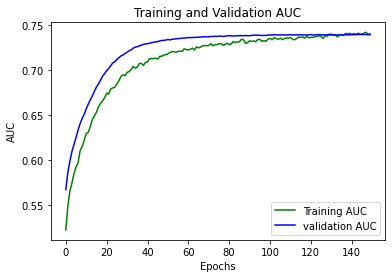

In [11]:

loss_train = history.history['auc']
loss_val = history.history['val_auc']
epochs = range(150)
plt.plot(epochs, loss_train, 'g', label='Training AUC')
plt.plot(epochs, loss_val, 'b', label='validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import roc_curve, auc
y_pred_keras = model1.predict([X_dynamic_test[:,-48:,:], X_static_test]).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

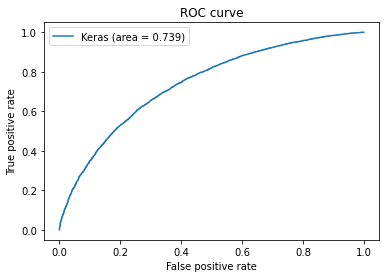

In [23]:

plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()